This file builds a basic recommender system that can recommend ted talks based on what are the topics of your interest.

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Yao
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('tedx_dataset.csv')
df.head()

,idx,main_speaker,title,details,posted,url,num_views
0,8d2005ec35280deb6a438dc87b225f89,Alexandra Auer,The intangible effects of walls,More barriers exist now than at the end of Wor...,Posted Apr 2020,https://www.ted.com/talks/alexandra_auer_the_i...,NaN
1,b3072cd11f40eb57fd259555264476c6,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...,If you're feeling anxious or fearful during th...,Posted Apr 2020,https://www.ted.com/talks/elizabeth_gilbert_it...,NaN
2,4adc9fee977fa04c357ed4c9b52aa3cc,Butterscotch,"""Accept Who I Am""","Firing off her formidable beatboxing skills, m...",Posted Apr 2020,https://www.ted.com/talks/butterscotch_accept_...,0.0
3,59c641a72b495d522a7932145d6c02b3,Ethan Lisi,What it's really like to have autism,"""Autism is not a disease; it's just another wa...",Posted Apr 2020,https://www.ted.com/talks/ethan_lisi_what_it_s...,NaN
4,d227f2faf6ec185e54436d86463f499b,Daniel Finkel,Can you solve the sea monster riddle?,"According to legend, once every thousand years...",Posted Apr 2020,https://www.ted.com/talks/daniel_finkel_can_yo...,0.0


In [6]:
df.shape

(4467, 7)

In [8]:
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [12]:
splitted = df['posted'].str.split(' ', expand=True)
# Create columns for month and year of the talk
df['month'] = splitted[1]
df['year'] = splitted[2].astype('int')
# df['month']
# df['year']

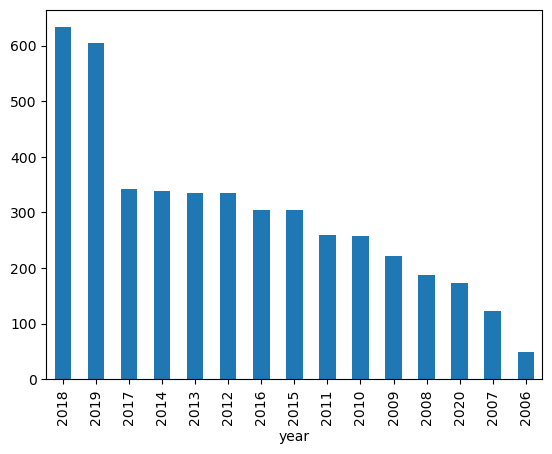

In [13]:
# Check the trend in the number of ted talks happening yearly
df['year'].value_counts().plot.bar()
plt.show()

In [14]:
# Combine the title and the details of the talk
df['details'] = df['title'] + ' ' + df['details']
# Remove the unnecessary information
df = df[['main_speaker', 'details']]
df.dropna(inplace=True)
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


In [15]:
data = df.copy()

### Text Preprocessing
In general data we obtained in the form of raw text requires a lot of preprocessing before it can be used to develop any model.<br>
Removal of stopwords, stemming, lemmatization, and removing punctuations are some steps that help us to convert the raw textual data into a usable format.<br>

Stopwords: Common words that add little semantic value(e.g., "the," "and," "is," "in"). Filtered out to reduce noise and focus on mearningful terms.<br>

Stemming: Crudely chops word endings to derive a root form, often without linguistic accuracy(e.g., "running" --> "run"). Reduces inflectional forms to a common base for analysis.<br>

Lemmatization: Uses vocabulary and grammar rules to reduce words to their canonical form(e.g., "better" --> "good", "am,is,are" --> "be"). More accurate than stemming by considering context and part of speech.

In [ ]:
# Remove stopwords
def remove_stopwords(text):
    stop_words = stopwords.words("english")
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)

    return output

In [17]:
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


In [20]:
# Remove punctuations
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    # creates a trasnlation table that deletes all characters in punctuations_list
    signal = str.maketrans('', '', punctuations_list) 
    return text.translate(signal)

df['details'] = df['details'].apply(lambda x: cleaning_punctuations(x))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


WordCloud is a visualization tool that helps us to visualize the occurrence of words.

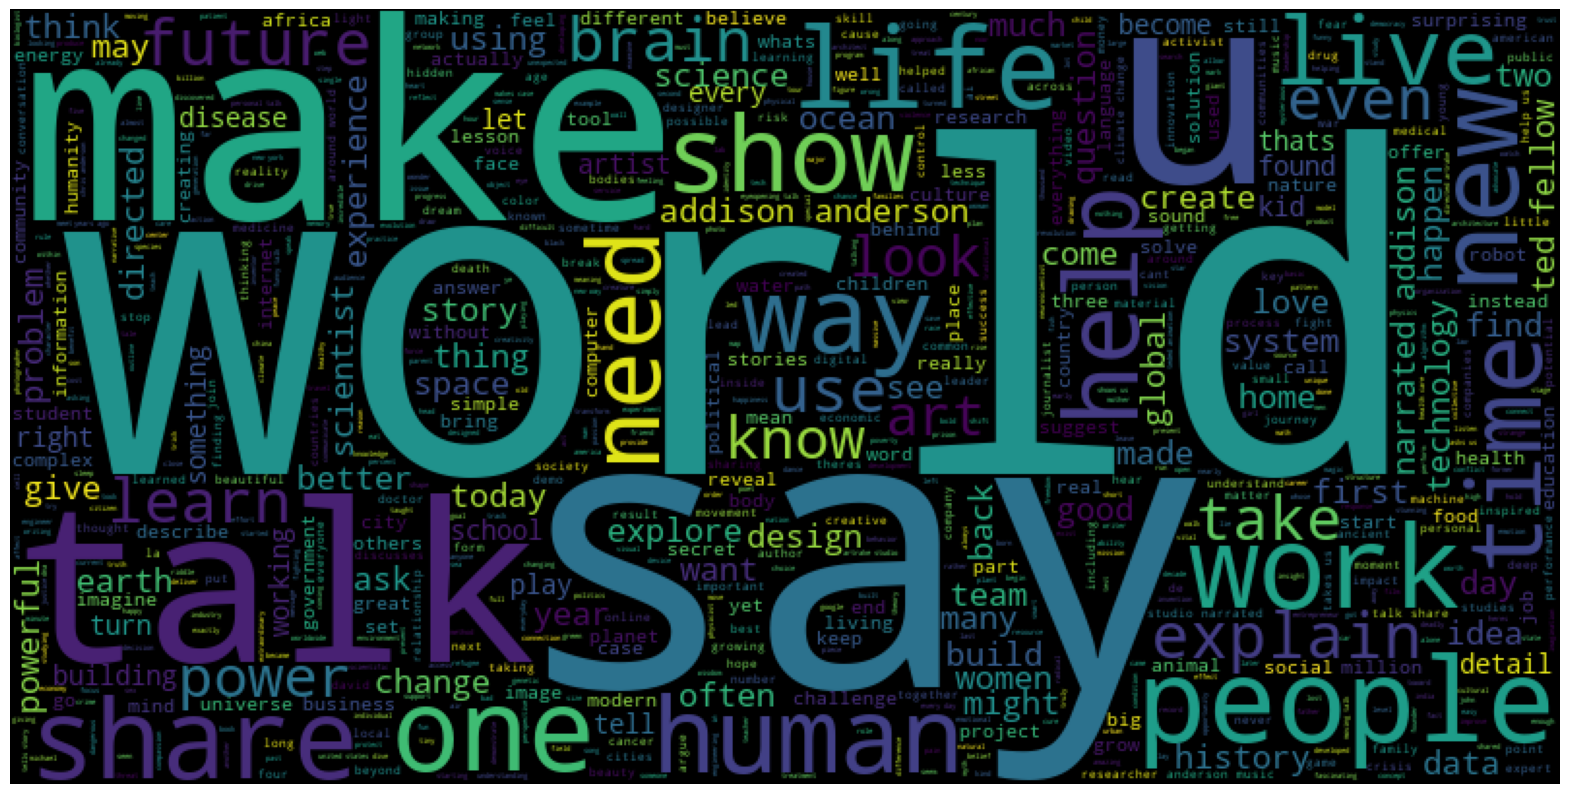

In [22]:
details_corpus = " ".join(df['details'])

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=800, height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

### Recommender System
As the details are all that we have about the talks we will use them to build our recommender system. We will use the Tf-IDF vectorizer to convert textual data into numerical representations.<br>
We will use two types of indicators to measure the similarity between our data and the input by the user:<br>
1. Cosine similarity: this is a useful metric to measure the similarity between the two objects.<br>
2. Pearson Correlation: Pearson's correlation coefficient formula is the most commonly used and the most popular formula to get the correlation coefficient.

In [23]:
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

TfidfVectorizer()

In [ ]:
def get_similarities(talk_content, data=df):
    # Getting vector for the input talk_content
    talk_array1 = vectorizer.transform(talk_content).toarray()

    # We will store similarity for each row of the dataset
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']

        # Getting vector for current talk
        talk_array2 = vectorizer.transform(data[data['details'] == details]['details']).toarray()
        
        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

        sim.append(cos_sim)
        pea.append(pea_sim)
    return sim, pea

In [28]:
def recommend_talks(talk_content, data=data):
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False,False], inplace=True)
    display(data[['main_speaker','details']].head())

In [ ]:
# Check recommender system with some examples
talk_content = ['Time Management and working hard to become successful in life']
recommend_talks(talk_content)

,main_speaker,details
1758,Laura Vanderkam,How to gain control of your free time There ar...
2173,Philip Krinks,Finding your personal mission in life Philip K...
66,Fang Ruan,Management lessons from Chinese business and p...
2075,Jessica Shortall,The US needs paid family leave — for the sake ...
2446,Susan Etlinger,What do we do with all this big data? Does a s...


In [30]:
talk_content = ["Work life balance is important in human's life. How do we achive this lifestyle in the world?"]
recommend_talks(talk_content)

,main_speaker,details
1262,Marc Bamuthi Joseph,"What soccer can teach us about freedom ""Soccer..."
375,Kelly Wanser,Emergency medicine for our climate fever As we...
155,David J. Bier,How guest worker visas could transform the US ...
4132,Samantha Power,A complicated hero in the war on dictatorship ...
4243,Paul Stamets,6 ways mushrooms can save the world Mycologist...
